<a href="https://colab.research.google.com/github/Randhir123/iisc-cds/blob/main/Randhir_M4_NB_MiniProject_2_Face_Mask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science

##  A program by IISc and TalentSprint

### Mini Project Notebook: Face Mask Detection using Convolutional Neural Networks

## Learning Objectives

At the end of the miniproject, you will be able to :

* load and extract features of images using ImageDataGenerator

* build the convolutional neural networks

* use the pre-trained models using keras applications

## Introduction

This project uses a Deep Neural Network, more specifically a Convolutional Neural Network, to differentiate between images of people, with masks, without masks and incorrectly placed masks. Manually built and pretrained networks will be used to perform this classification task.

**Face-Mask-Detection-Using-CNN**

* Outbreak of the Coronavirus pandemic has created various changes in the lifestyle of everyone around the world.
* Among these changes, wearing a mask has been very vital to every individual.
* Detection of people who are not wearing masks is a challenge due to the large populations.
* This face mask detection project can be used in schools, hospitals, banks, airports etc as a digitalized scanning tool.
  - The technique of detecting people’s faces and segregating them into three classes namely the people with masks and people without masks and partial masks is done with the help of image processing and deep learning.
* With the help of this project, a person who is monitoring the face mask status for a particular firm can be seated in a remote area and still monitor efficiently and give instructions accordingly.

![img](https://cdn.iisc.talentsprint.com/CDS/MiniProjects/dataset-images-with-mask.jpg)

## Dataset

The data for this mini-project is collected from various sources including the masked images from internet and general frontal face images considered as without mask. This dataset consists of 5029 train images and 1259 test images with 3 classes `with_mask`, `without_mask` and `partial_mask`

Many people do not correctly wear their masks due to bad practices, bad behaviors or vulnerability of individuals (e.g., children, old people). For these reasons, several mask wearing campaigns intend to sensitize people about this problem and good practices. In this sense, this work proposes three types of masked face detection dataset:

- Without Mask/ With Mask/ Partial Mask

Note that this dataset contains some annotated (artificially generated) masks to augment the 'masked' data category.

## Problem Statement

To build and implement a Convolutional Neural Network model to classify between masked/unmasked/partially masked faces.

## Grading = 10 Points

In [1]:
#@title Download the data
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/MP2_FaceMask_Dataset.zip
!unzip -qq MP2_FaceMask_Dataset.zip
print("Data Downloaded Successfuly!!")

Data Downloaded Successfuly!!


### Import Required packages

In [2]:
import numpy as np
import PIL
from matplotlib import pyplot as plt
import glob, os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense,Dropout
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint

## Data Loading and preprocessing (2 points)

### Analyze the shape of images and distribution of classes

In [ ]:
# YOUR CODE HERE

### Load the images using ImageDataGenerator

There are two main steps involved in creating the generator.
1. Instantiate ImageDataGenerator with required arguments to create an object
2. Use the `flow_from_directory` command depending on how your data is stored on disk. This is the command that will allow you to generate and get access to batches of data on the fly.

Hint: [link](https://keras.io/api/preprocessing/image/)

In [3]:
TRAINING_DIR = "/content/MP2_FaceMask_Dataset/train/"
VALIDATION_DIR = "/content/MP2_FaceMask_Dataset/test/"

In [4]:
# YOUR CODE HERE
# Training sample
gen = ImageDataGenerator(rescale = 1.0/255,
                         width_shift_range = 0.005,
                         height_shift_range = 0.005,
                         rotation_range = 0,
                         horizontal_flip = True)

In [5]:
# Define batch size and image dimensions
batch_size = 32
img_height = 256
img_width = 256

# Create a generator for training data
train_generator = gen.flow_from_directory(
    TRAINING_DIR,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  # or 'binary' or None, depending on your task
    shuffle=True  # Shuffle the data for better training
)

# Create a generator for training data
test_generator = gen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  # or 'binary' or None, depending on your task
    shuffle=True  # Shuffle the data for better training
)

Found 5029 images belonging to 3 classes.
Found 1259 images belonging to 3 classes.


In [30]:
def class_distribution(generator, path):
  # Get class indices (mapping of class names to class indices)
  class_indices = generator.class_indices

  # Count the number of images per class
  class_counts = {class_name: 0 for class_name in class_indices.keys()}

  # Iterate through the directory to count images per class
  for class_name in class_indices.keys():
      class_dir = os.path.join(path, class_name)
      num_images = len(os.listdir(class_dir))
      class_counts[class_name] = num_images

  # Print class distribution
  print(f"\nClass distribution for {path}:")
  for class_name, count in class_counts.items():
      print(f"{class_name}: {count} images")

class_distribution(train_generator, TRAINING_DIR)
class_distribution(test_generator, VALIDATION_DIR)
num_classes = train_generator.num_classes
print(f"Number of classes: {num_classes}")


Class distribution for /content/MP2_FaceMask_Dataset/train/:
partial_mask: 1294 images
with_mask: 1624 images
without_mask: 2138 images

Class distribution for /content/MP2_FaceMask_Dataset/test/:
partial_mask: 323 images
with_mask: 406 images
without_mask: 534 images
Number of classes: 3


### Visualize the sample images of each class using data generator

Hint: plt.subplot

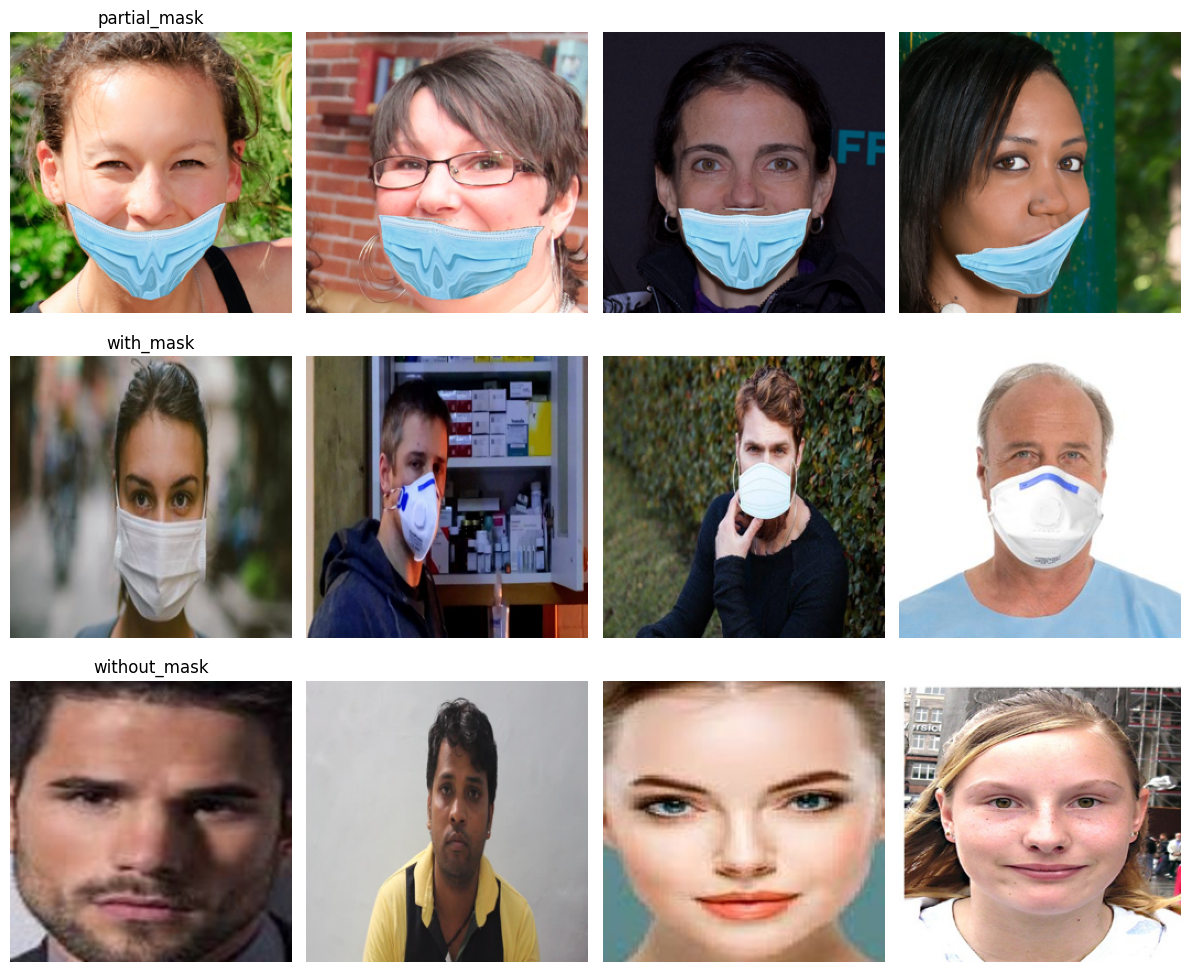

In [27]:
# YOUR CODE HERE

# Get class indices (mapping of class names to class indices)
class_indices = train_generator.class_indices

# Invert the mapping to get class names from indices
class_names = {v: k for k, v in class_indices.items()}

# Create a figure for plotting
plt.figure(figsize=(12, 10))

# Number of sample images to display per class
num_samples_per_class = 4

# Iterate over each class and plot sample images
for class_idx, class_name in class_names.items():
    # Find the first batch of images for the current class
    idx = np.where(train_generator.classes == class_idx)[0][:num_samples_per_class]

    # Load and plot each image
    for i, img_idx in enumerate(idx):
        # Load the original image
        img_path = os.path.join(TRAINING_DIR, train_generator.filenames[img_idx])

        try:
            img = load_img(img_path)
            # Resize the image for visualization
            img = img.resize((img_width, img_height))
            # Convert image to array for plotting
            img_array = img_to_array(img) / 255.  # Rescale to [0, 1]

            ax = plt.subplot(len(class_names), num_samples_per_class, class_idx * num_samples_per_class + i + 1)
            ax.imshow(img_array)
            ax.axis('off')
            if i == 0:
                ax.set_title(class_name)
        except FileNotFoundError as e:
            print(f"Error loading image: {img_path}. {e}")

plt.tight_layout()
plt.show()

## Build the CNN model using Keras (4 points)



**Convolutional Neural Network:** A neural network in which at least one layer is a convolutional layer. A typical convolutional neural network consists of some combination of the following layers:

* convolutional layers
* pooling layers
* dense layers


**Conv2D**

Passing an image with input shape of 3-D and to calculate the output:

 $O = \frac{n - f + 2p}{s} + 1$

 where

 $n$ = image dimension

 $f$ = filter size

 $p$ = padding

 $s$ = stride

**MaxPool**

The resulting output, when using the "valid" padding option, has a spatial shape (number of rows or columns) of:

O = `math.floor`$(\frac{input shape - pool size)}{ strides}) + 1$ (when input shape >= pool size)

The resulting output shape when using the "same" padding option is:

O = `math.floor`$(\frac{input shape - 1}{strides}) + 1$

by default, stride = None, so stride is same as pool size

Task-flow
* Initialize the network of convolution, maxpooling and dense layers
* Define the optimizer and loss functions
* Fit the model and evaluate the model

In [8]:
# YOUR CODE HERE
# Initialize the model
model = tf.keras.Sequential()

model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape=(img_height,img_width,3)))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 246016)            0         
                                                                 
 dense (Dense)               (None, 128)               3

In [9]:
# Define optimizer and loss function
optimizer = Adam(lr=0.01)
loss = CategoricalCrossentropy()

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])


In [10]:
# Fit the model
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=3,
    validation_data=test_generator,
    validation_steps=len(test_generator)
)


<ipython-input-10-7459b00a4475>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/3
158/158 [==============================] - 710s 4s/step - loss: 0.7765 - accuracy: 0.7610 - val_loss: 0.2109 - val_accuracy: 0.9190
Epoch 2/3
158/158 [==============================] - 687s 4s/step - loss: 0.2877 - accuracy: 0.9059 - val_loss: 0.2031 - val_accuracy: 0.9500
Epoch 3/3
158/158 [==============================] - 719s 5s/step - loss: 0.2023 - accuracy: 0.9382 - val_loss: 0.1436 - val_accuracy: 0.9531


In [11]:
#Save Model to file
model.save("facemask_model.keras")

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')

#Save Model to file in google drive
model.save('/content/gdrive/MyDrive/facemask_model.keras')

Mounted at /content/gdrive


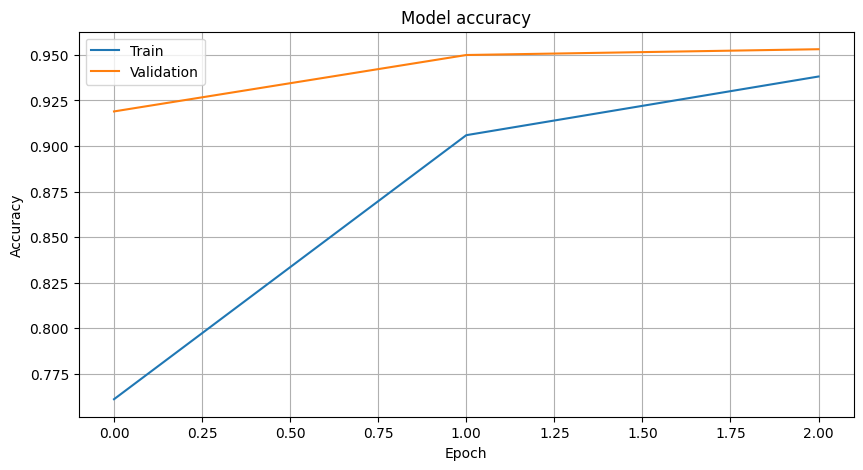

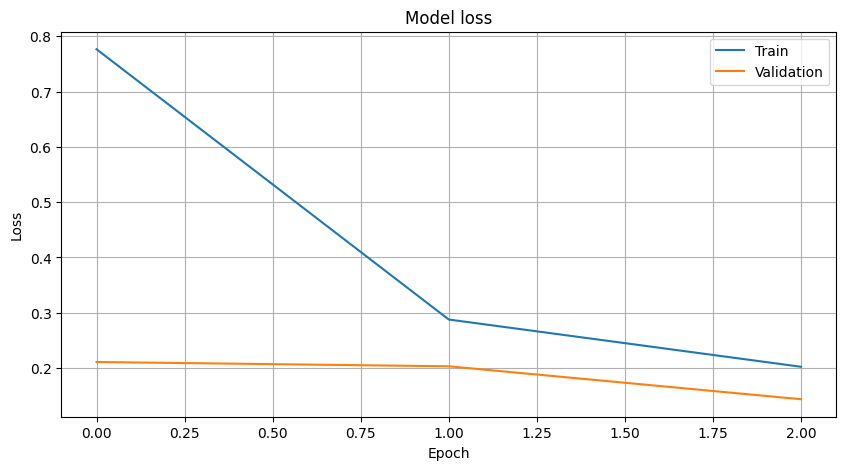

In [13]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True)
plt.show()

## Transfer learning (4 points)

Transfer learning consists of taking features learned on one problem, and leveraging them on a new, similar problem.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

For eg. Using VGG16, we remove the last layer which takes a probability for each of the 1000 classes in the ImageNet and replaces it with a layer that takes 3 probabilities in our case.

### Use the pre-trained models ([VGG16](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16) or [ResNet50](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50))

* Load the pre-trained model
* Fit and evaluate the data

Hint: [How to use pre-trained model](https://towardsdatascience.com/step-by-step-guide-to-using-pretrained-models-in-keras-c9097b647b29)

#### Expected accuracy: More than 90%

Task-flow
* Initialize the network with the weights of Imagenet
* Fine tune the network by modifying fully connected layers.
* Re-train the model with our problem data

In [28]:
# YOUR CODE HERE
# Load pre-trained VGG16 model without top layers (include_top=False)
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
vgg_base.trainable = False


58889256/58889256 [==============================] - 0s 0us/step


In [37]:
# Initialize a new model
model = Sequential()

# Add the pre-trained VGG base model
model.add(vgg_base)

# Add custom layers on top of VGG
model.add(Flatten())
model.add(Dense(256, activation='relu'))
#model.add(BatchNormalization())
model.add(Dropout(rate=0.2))
model.add(Dense(num_classes, activation='softmax'))  # Output layer for multi-class classification

# Print model summary to see the architecture
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense_3 (Dense)             (None, 256)               8388864   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 3)                 771       
                                                                 
Total params: 23104323 (88.14 MB)
Trainable params: 8389635 (32.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [38]:
# Compile the model
optimizer = Adam(lr=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [39]:
# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=1,
    validation_data=test_generator,
    validation_steps=len(test_generator)
)


158/158 [==============================] - 4689s 30s/step - loss: 0.3645 - accuracy: 0.9195 - val_loss: 0.0728 - val_accuracy: 0.9682


In [40]:
#Save Model to file
model.save("facemask_model_vgg16.keras")

In [41]:
from google.colab import drive
drive.mount('/content/gdrive')

#Save Model to file in google drive
model.save('/content/gdrive/MyDrive/facemask_model_vgg16.keras')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Capture the live image using the below code cell and predict

<IPython.core.display.Javascript object>

Saved to photo.jpg


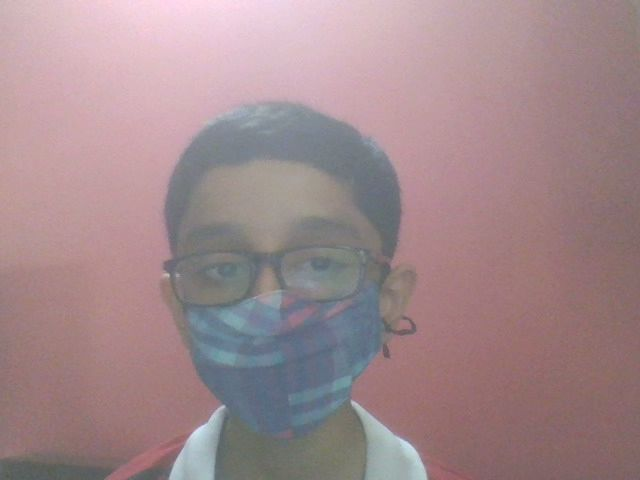

In [25]:
#@title Capture the photo
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  display(Image(filename))
except Exception as err:
  print(str(err))

After executing above cell and capturing the photo, load the captured photo and predict with model.

**Note:**
* Convert the image to numpy array and resize to the shape which the model accepts.
* Extend the dimension (to 4-D shape) of an image, as the model is trained on a batch of inputs.

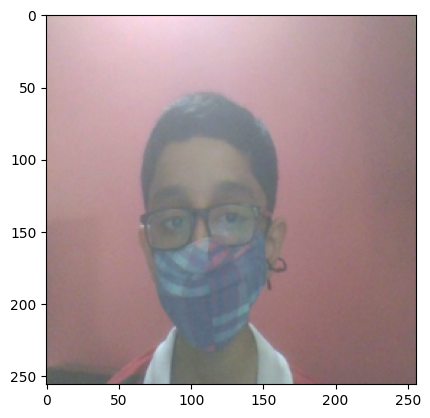

In [35]:
features = PIL.Image.open("photo.jpg")
image = features.resize((256, 256))
plt.imshow(image);
# YOUR CODE HERE to predict the image
image = np.array(image)
image = np.expand_dims(image, axis=0)  # Add batch dimension
image = preprocess_input(image)

In [39]:
predictions = model.predict(image)

predicted_class = np.argmax(predictions)
print("Predicted class:", class_names[predicted_class])

1/1 [==============================] - 1s 1s/step
Predicted class: partial_mask


### Instructions for preparing Kaggle competition predictions

Important: Refer the [Kaggle Team Creation Instructions Doc](https://drive.google.com/file/d/1IgkHOXtJOw_wfsTrHBTl7kOOSMzhh3Ph/view?usp=drive_link)

* Load the image paths from Kaggle testset using `glob`
* Read the Images using `PIL.Image.open` and resize to required shape.
* Get the predictions using trained model and prepare a csv file
  - FC layer of DeepNet model gives output for each class, consider the maximum value among all classes as prediction using `np.argmax`.
* Predictions (csv) file should contain 2 columns as Sample_Submission.csv
  - First column is the img_path which is considered as index
  - Second column is prediction in decoded form (for eg. with_mask, partial_mask, without_mask).
  - Note that at the time of submission to Kaggle, predictions need to be sorted in ascending order i.e, same as sample submission file.

<font color='magenta'>If you are unable to download the data and sample submission from the Kaggle Competition site then please use the download cell below.</font>


In [6]:
#@title Download test data and SampleSubmission file for Kaggle submission
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/FaceMask_Kaggle_test.zip
!unzip -qq FaceMask_Kaggle_test.zip
!wget -qq https://cdn.iisc.talentsprint.com/CDS/Datasets/Sample_Submission.csv
print("Data Downloaded Successfuly!!")

Data Downloaded Successfuly!!


In [42]:
from google.colab import drive
drive.mount('/content/gdrive')

model = tf.keras.models.load_model('/content/gdrive/MyDrive/facemask_model_vgg16.keras')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [8]:
kaggle_test_dir = '/content/FaceMask_Kaggle_test'
image_paths = glob.glob(kaggle_test_dir + '/*.jpg') + glob.glob(kaggle_test_dir + '/*jpeg')

In [10]:
def extract_numeric_order(file_path):
    return int(re.search(r'\d+', file_path).group())

In [11]:
# Function to load and preprocess images
def preprocess_image(image_path):
    image = PIL.Image.open(image_path)
    image = image.resize((256, 256))  # Resize image to match input size for VGG16 or ResNet50
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    image = preprocess_input(image)  # Preprocess image according to the requirements of the model
    return image

# Preprocess all images
preprocessed_images = [preprocess_image(image_path) for image_path in image_paths]


In [43]:
# Make predictions on all preprocessed images
predictions = [model.predict(image) for image in preprocessed_images]

1/1 [==============================] - 1s 627ms/step


In [44]:
class_names = ['partial_mask','with_mask','without_mask']
decoded_predictions = [class_names[np.argmax(pred)] for pred in predictions]

In [45]:
import re
prefix = "/content/"
new_path = [image_path.removeprefix(prefix) for image_path in image_paths]

predictions_df = pd.DataFrame({'img_path': new_path, 'label': decoded_predictions})

# Add a column for sorting based on numerical order of file names
predictions_df['numeric_order'] = predictions_df['img_path'].apply(extract_numeric_order)

# Sort predictions by numerical order of file names
predictions_df = predictions_df.sort_values(by='numeric_order')

# Drop the sorting column if not needed in final output
predictions_df = predictions_df.drop(columns=['numeric_order'])

# Save predictions to CSV file
predictions_df.to_csv('predictions.csv', index=False)


### Report Analysis

- Compare the accuracies for the Pre-trained vs CNN models
- What process was followed to tune the hyperparameters?
- Which model detects the mask/no mask/ partial mask more accurately with the live pictures?
- Discuss the confusion matrix in terms of the misclassifications